In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import tqdm
import scipy
import umap
import copy

from methods import RandomWalk2D

In [3]:
boxsize=2*np.pi
res = 100
mesh = np.linspace(-boxsize, boxsize, res)
X, Y = np.meshgrid(mesh, mesh)
mesh = np.stack([X, Y], axis=-1)
rw = RandomWalk2D()
rs, vs = rw.generate_data(1, 4000)

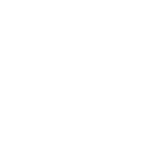

In [4]:
fig, ax = plt.subplots(figsize=(2,2))
ax.plot(*rs.T, color='white', alpha=1.0)
ax.axis('off')
ax.set_xlim(-boxsize, boxsize)
ax.set_ylim(-boxsize, boxsize)
ax.set_aspect('equal')
fig.tight_layout(pad=0)
fig.savefig("figures/random_walk_2d.png", dpi=300)

In [6]:
def multicolor_plot(rs, values, fig=None, ax=None, cmap='coolwarm', **kwargs):
    """
    rs: (n, 2) array of positions
    values: (n,) array of values
    cmap: str, name of matplotlib colormap
    """
    if fig is None:
        fig, ax = plt.subplots(figsize=(2,2))
    from matplotlib.colors import Normalize
    cmap = plt.get_cmap(cmap)
    norm = Normalize(vmin=values.min(), vmax=values.max())
    colors = cmap(norm(values))
    for i in range(len(rs) - 1):
        ax.plot(rs[i:i+2, 0], rs[i:i+2, 1], color=colors[i], **kwargs)
    return fig, ax

from methods import place_cells, head_direction_cells, border_cells

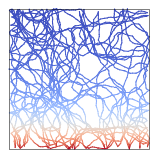

In [7]:
fig, ax = multicolor_plot(rs, border_cells(rs, phases=1)[:, 0])
# Plot the bounding box
ax.plot([-boxsize, boxsize, boxsize, -boxsize, -boxsize],
         [-boxsize, -boxsize, boxsize, boxsize, -boxsize], color='black', alpha=0.5)

ax.axis('equal')
ax.axis('off')
ax.set_xlim(-boxsize, boxsize)
ax.set_ylim(-boxsize, boxsize)
fig.tight_layout(pad=0)
fig.savefig("figures/border_cells.png", dpi=300)


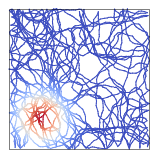

In [8]:
fig, ax = multicolor_plot(rs, place_cells(rs, phases=1)[:, 0])
# Plot the bounding box
ax.plot([-boxsize, boxsize, boxsize, -boxsize, -boxsize],
         [-boxsize, -boxsize, boxsize, boxsize, -boxsize], color='black', alpha=0.5)

ax.axis('equal')
ax.axis('off')
ax.set_xlim(-boxsize, boxsize)
ax.set_ylim(-boxsize, boxsize)
fig.tight_layout(pad=0)
fig.savefig("figures/place_cells.png", dpi=300)

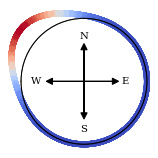

In [32]:
t = np.linspace(-np.pi, np.pi, 100)
fig,ax = plt.subplots(figsize=(2,2))
ax.plot(np.cos(t), np.sin(t), color='black', alpha=0.5)
angles = vs / np.linalg.norm(vs, axis=1)[:, None]
hdcs = head_direction_cells(vs, phases=10)
angles = angles * (1 + 0.3*hdcs[:, 0:1]/hdcs[:,0].max())
ax.scatter(*angles.T, c=hdcs[:,0], cmap='coolwarm', s=25)
ax.axis('equal')
ax.axis('off')
fig.tight_layout(pad=0)
# add compass
compass = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_artist(compass)
ax.arrow(0, 0, 0.45, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.text(0.6, 0, 'E', verticalalignment='center')
ax.arrow(0, 0, 0, 0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.text(0, 0.68, 'N', horizontalalignment='center')
ax.arrow(0, 0, -0.5, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.text(-0.85, 0, 'W', verticalalignment='center')
ax.arrow(0, 0, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.text(0, -0.8, 'S', horizontalalignment='center')
fig.savefig("figures/head_direction_cells.png", dpi=300)

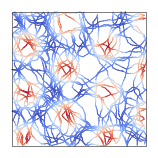

In [10]:
from methods import HexagonalGCs
import torch
grids = HexagonalGCs(ncells=1, f=1/(1.2*np.pi))
activity = grids(torch.tensor(rs).float()).detach().numpy()

fig, ax = multicolor_plot(rs, activity[:, 0])
# Plot the bounding box
ax.plot([-boxsize, boxsize, boxsize, -boxsize, -boxsize],
         [-boxsize, -boxsize, boxsize, boxsize, -boxsize], color='black', alpha=0.5)

ax.axis('equal')
ax.axis('off')
fig.tight_layout(pad=0)
fig.savefig("figures/grid_cells.png", dpi=300)

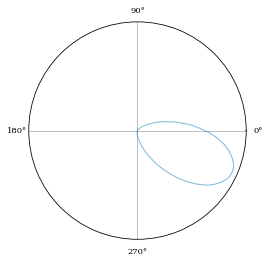

In [11]:
# create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
hdcs = head_direction_cells(vs, phases=10)
bins = np.linspace(-np.pi, np.pi, 100)
hist = scipy.stats.binned_statistic(np.arctan2(*vs.T), hdcs[:, 0], bins=bins, statistic='mean')
ax.plot(hist.bin_edges[:-1], hist.statistic / hist.statistic.max(), alpha=0.5)
#ax.scatter(np.arctan2(*vs.T), hdcs[:, 0], c=hdcs[:,0], alpha=0.5, s=1, cmap='coolwarm')
#ax.hist(np.arctan2(*vs.T), bins=bins, weights=hdcs[:, 0], color='grey', alpha=0.5, density=True)
ax.set_yticks([])#ax.get_yticks()[1:-1])
ax.set_xticks(ax.get_xticks()[::2])
#ax.axis('off')